# Imports


In [ ]:
# !pip install keras-tuner --upgrade

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

In [ ]:
tf.random.set_seed(0)

In [ ]:
import time
# import keras_tuner as kt

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



# Load Data

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Turbofan_Dataset/final_datasets_normalized/"

In [ ]:
# Load data and drop irrelevant columns

df_train = pd.read_csv(path + "TRAINING_SET_FULL.csv")
df_test = pd.read_csv(path + "TEST_SET_FULL.csv")

drop_cols = ["cycle","setting3","s1","s5","s10","s16","s18","s19","fail_30"]
corr_cols = ["s11","s4","s15","s17","s2","s3","s8","s13","s9","s14","s12","s7","s20"]
feature_cols = ['cycle_norm', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
prediction_col = 'RUL'

train_set = df_train.drop(drop_cols, axis=1)
test_set = df_test.drop(drop_cols, axis=1)

In [ ]:
# Move cycle_norm column first for convenience

column_to_move = train_set.pop("cycle_norm")
train_set.insert(0, "cycle_norm", column_to_move)

column_to_move = test_set.pop("cycle_norm")
test_set.insert(0, "cycle_norm", column_to_move)

In [ ]:
train_set

,cycle_norm,id,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,0.000000,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,0.002770,1,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,0.005540,1,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,0.008310,1,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,0.011080,1,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.540166,100,0.477011,0.250000,0.686747,0.587312,0.782917,1.0,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,4
20627,0.542936,100,0.408046,0.083333,0.701807,0.729453,0.866475,1.0,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,3
20628,0.545706,100,0.522989,0.500000,0.665663,0.684979,0.775321,1.0,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,2
20629,0.548476,100,0.436782,0.750000,0.608434,0.746021,0.747468,1.0,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,1


# Sequence Creation

In [ ]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [ ]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    data_gen = (list(gen_train_data(df[df['id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
# data_array = gen_data_wrapper(train_set, sequence_length=4, columns=feature_cols)
# data_array.shape

In [ ]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
def gen_test_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
    
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    # keep only last window
    if sequence_length > 31:
      print("Too big window")
    else:
      last_labels = [label[-1] for label in label_gen] 
      



    last_labels = np.concatenate(last_labels).astype(np.float32)
    # return label_array
    return last_labels


In [ ]:
sequence_length = 20

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)


for train_unit, val_unit in gss.split(train_set['id'].unique(), groups=train_set['id'].unique()):
    train_unit = train_set['id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = train_set['id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(train_set, sequence_length, feature_cols, train_unit)
    train_split_label = gen_label_wrapper(train_set, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(train_set, sequence_length, feature_cols, val_unit)
    val_split_label = gen_label_wrapper(train_set, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(train_set, sequence_length, feature_cols)
label_array = gen_label_wrapper(train_set, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(test_set[test_set['id']==id], sequence_length, feature_cols, -99.))
           for id in test_set['id'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

test_label_array = gen_test_label_wrapper(test_set, sequence_length, ['RUL'])


# Model Definition

In [ ]:
# Defining LSTM model

model = tf.keras.Sequential()
# model.add(tf.keras.layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(tf.keras.layers.InputLayer(input_shape=(20, 18)))

model.add(tf.keras.layers.LSTM(32, activation='tanh'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))


In [ ]:
# InputLayer(input_shape=(20, 18)),  
(sequence_length, train_array.shape[2])

(20, 18)

# Training


In [ ]:
start = time.time()



model.compile(loss='mean_squared_error', optimizer="adam")  # the model is recompiled to reset the optimizer

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=10,
                   batch_size=32)

Epoch 1/10
471/471 [==============================] - 6s 9ms/step - loss: 11569.6240 - val_loss: 9122.8926
Epoch 2/10
471/471 [==============================] - 4s 8ms/step - loss: 9105.4775 - val_loss: 7265.7100
Epoch 3/10
471/471 [==============================] - 3s 7ms/step - loss: 7450.5386 - val_loss: 5941.9116
Epoch 4/10
471/471 [==============================] - 4s 8ms/step - loss: 6286.9507 - val_loss: 5017.2280
Epoch 5/10
471/471 [==============================] - 4s 7ms/step - loss: 5468.1035 - val_loss: 4405.9419
Epoch 6/10
471/471 [==============================] - 3s 7ms/step - loss: 4888.2124 - val_loss: 3888.8010
Epoch 7/10
471/471 [==============================] - 3s 7ms/step - loss: 3779.1672 - val_loss: 2598.2625
Epoch 8/10
471/471 [==============================] - 3s 7ms/step - loss: 3005.4419 - val_loss: 2071.0479
Epoch 9/10
471/471 [==============================] - 4s 8ms/step - loss: 2543.0471 - val_loss: 1696.7336
Epoch 10/10
471/471 [========================

In [ ]:
end = time.time()
print(f"Training time {end - start:.2f} sec")

Training time 42.91 sec


# Evaluation

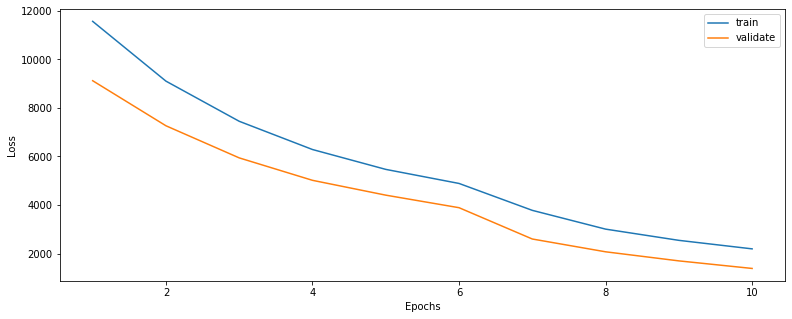

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [ ]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(test_label_array, y_hat_test)

train set RMSE:42.73553466796875, R2:0.5579822329207917
test set RMSE:17.23444366455078, R2:0.8279974121179458


In [ ]:
test_label_array

array([112.,  98.,  69.,  82.,  91.,  93.,  91.,  95., 111.,  96.,  97.,
       124.,  95., 107.,  83.,  84.,  50.,  28.,  87.,  16.,  57., 111.,
       113.,  20., 145., 119.,  66.,  97.,  90., 115.,   8.,  48., 106.,
         7.,  11.,  19.,  21.,  50., 142.,  28.,  18.,  10.,  59., 109.,
       114.,  47., 135.,  92.,  21.,  79., 114.,  29.,  26.,  97., 137.,
        15., 103.,  37., 114., 100.,  21.,  54.,  72.,  28., 128.,  14.,
        77.,   8., 121.,  94., 118.,  50., 131., 126., 113.,  10.,  34.,
       107.,  63.,  90.,   8.,   9., 137.,  58., 118.,  89., 116., 115.,
       136.,  28.,  38.,  20.,  85.,  55., 128., 137.,  82.,  59., 117.,
        20.], dtype=float32)

In [ ]:
y_hat_test.reshape(100,)

array([117.82425  , 117.76484  ,  43.127018 ,  84.18568  , 100.177086 ,
       114.61552  , 114.017815 ,  90.24967  , 117.481766 ,  82.11434  ,
        97.47835  ,  93.0754   ,  92.545006 , 117.59738  , 117.80942  ,
       117.145424 ,  54.93764  ,  35.080654 ,  99.95287  ,  14.582066 ,
        74.771286 , 117.79819  , 117.814735 ,  21.700792 , 117.82055  ,
       117.64341  , 108.85047  ,  99.282814 ,  97.41313  ,  97.52997  ,
        10.131994 ,  51.785625 , 117.21117  ,   9.215631 ,   8.936852 ,
        17.019129 ,  29.411882 ,  42.956944 , 117.82281  ,  29.372694 ,
        37.838207 ,  14.019121 ,  76.44402  , 117.770195 ,  70.74711  ,
        49.78808  , 116.61789  , 116.42792  ,  23.327127 , 116.55071  ,
       101.00009  ,  36.451668 ,  31.052267 , 117.75743  , 116.36081  ,
         8.923931 , 102.624756 ,  49.354034 , 117.81997  , 107.63724  ,
        21.779804 ,  47.30073  ,  90.31088  ,  25.29346  , 117.82011  ,
        17.35711  , 117.71117  ,   9.378815 , 117.80394  , 102.0